In [32]:
import os
import numpy as np 
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34, ResNet34_Weights
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score

In [33]:
# Load the data
train = pd.read_csv("../input/classify-leaves/train.csv")
test = pd.read_csv("../input/classify-leaves/test.csv")

train.head()

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [34]:
train.describe

<bound method NDFrame.describe of                   image                    label
0          images/0.jpg         maclura_pomifera
1          images/1.jpg         maclura_pomifera
2          images/2.jpg         maclura_pomifera
3          images/3.jpg         maclura_pomifera
4          images/4.jpg         maclura_pomifera
...                 ...                      ...
18348  images/18348.jpg          aesculus_glabra
18349  images/18349.jpg  liquidambar_styraciflua
18350  images/18350.jpg            cedrus_libani
18351  images/18351.jpg      prunus_pensylvanica
18352  images/18352.jpg          quercus_montana

[18353 rows x 2 columns]>

In [35]:
train.label.value_counts()

maclura_pomifera            353
ulmus_rubra                 235
prunus_virginiana           223
acer_rubrum                 217
broussonettia_papyrifera    214
                           ... 
cedrus_deodara               58
ailanthus_altissima          58
crataegus_crus-galli         54
evodia_daniellii             53
juniperus_virginiana         51
Name: label, Length: 176, dtype: int64

torch.Size([3, 224, 224])


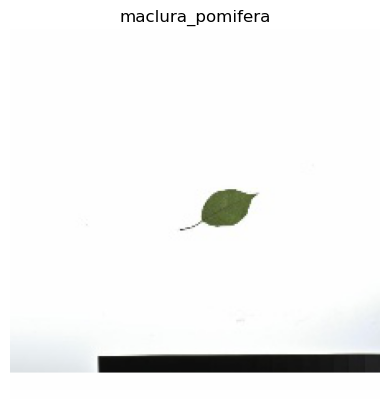

In [36]:
img1_path = os.path.join('../input/classify-leaves', train.loc[0, 'image'])
img_1 = Image.open(img1_path)
img_size = transforms.ToTensor()
print(img_size(img_1).shape)
plt.imshow(img_1)
plt.title(train.loc[0, 'label'])
plt.axis('off')
plt.show()

In [37]:
class_to_num = dict(zip(list(train.loc[:, 'label'].unique()), range(len(train.label.unique()))))
num_to_class = {y: x for x, y in class_to_num.items()}

In [38]:
class LeavesDataset(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_ratio=0.2):      
        self.file_path = file_path
        self.mode = mode
        self.data_info = pd.read_csv(csv_path)
        self.data_len = len(self.data_info.index)
        self.train_len = int(self.data_len * (1 - valid_ratio))
        
        if mode == 'train':
            self.train_image = np.asarray(self.data_info.loc[:self.train_len, 'image'])
            self.train_label = np.asarray(self.data_info.loc[:self.train_len, 'label'])
            self.image_arr = self.train_image
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.loc[self.train_len:, 'image'])
            self.valid_label = np.asarray(self.data_info.loc[self.train_len:, 'label'])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode == 'test':
            self.test_image = np.asarray(self.data_info.loc[:, 'image'])
            self.image_arr = self.test_image
            
        self.real_len = len(self.image_arr)
        
        print('Finished reading %s dataset. %d number samples found.' % (mode, self.real_len))
        
    def __getitem__(self, index):
        image_path = self.image_arr[index]
        image = Image.open(os.path.join(self.file_path, image_path))
        
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),   # 随机水平翻转 选择一个概率
                transforms.RandomVerticalFlip(p=0.5),     # 随机垂直翻转 选择一个概率
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                
                ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                
            ])
            
        image = transform(image)
        
        if self.mode == 'test':
            return image
        else:
            label = self.label_arr[index]
            label_num = class_to_num[label]
            return image, label_num
        
    def __len__(self):
        return self.real_len

In [39]:
train_path = '../input/classify-leaves/train.csv'
test_path = '../input/classify-leaves/test.csv'
image_path = '../input/classify-leaves'

train_dataset = LeavesDataset(train_path, image_path, mode='train', valid_ratio=0.2)
valid_dataset = LeavesDataset(train_path, image_path, mode='valid', valid_ratio=0.2)
test_dataset = LeavesDataset(test_path, image_path, mode='test')

Finished reading train dataset. 14683 number samples found.
Finished reading valid dataset. 3671 number samples found.
Finished reading test dataset. 8800 number samples found.


In [40]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=4)

In [41]:
model = resnet34(weights=ResNet34_Weights.DEFAULT, progress=True)
# print(model)

In [42]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
input_channel = model.fc.in_features
model.fc = nn.Linear(input_channel, 176)
model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
epochs = 50

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [44]:
model_path = '/kaggle/working/model.ckpt'
best_acc = 0
for epoch in range(epochs):
    for step, (x, y) in enumerate(train_loader):
        model.train()
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = loss_func(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0:
            model.eval()
            with torch.no_grad():
                accuracy = []
                for valid_x, valid_y in valid_loader:
                    valid_x = valid_x.to(device)
                    valid_y = valid_y.to(device)
                    valid_output = model(valid_x)
                    acc = accuracy_score(valid_y.cpu().data.numpy(), torch.max(valid_output, 1)[1].cpu().data.numpy())
                    accuracy.append(acc)
                    
                accuracy = np.mean(accuracy)
                print('Epoch: {}, step: {}, loss:{:.4f}, valid_accuracy: {:.4f}'.format(epoch + 1, step, loss.cpu().data.numpy(), accuracy))
                
    if accuracy >= best_acc:
        best_acc = accuracy
        torch.save(model.state_dict(), model_path)
        print('Saving model with an accuracy of {}'.format(best_acc))
#     else:
#         print('The accuracy of this epoch is not good as the last epoch : {}. Kernel shut down.'.format(best_acc))
#         break   

Epoch: 1, step: 0, loss:5.4778, valid_accuracy: 0.0120
Epoch: 1, step: 50, loss:5.3328, valid_accuracy: 0.0111
Epoch: 1, step: 100, loss:4.6903, valid_accuracy: 0.0398
Epoch: 1, step: 150, loss:4.3535, valid_accuracy: 0.0392
Epoch: 1, step: 200, loss:3.5396, valid_accuracy: 0.0897
Epoch: 1, step: 250, loss:3.0332, valid_accuracy: 0.1086
Epoch: 1, step: 300, loss:3.0702, valid_accuracy: 0.1573
Epoch: 1, step: 350, loss:2.4766, valid_accuracy: 0.1548
Epoch: 1, step: 400, loss:2.2917, valid_accuracy: 0.2132
Epoch: 1, step: 450, loss:2.6918, valid_accuracy: 0.2567
Saving model with an accuracy of 0.25666351606805293
Epoch: 2, step: 0, loss:2.8052, valid_accuracy: 0.2118
Epoch: 2, step: 50, loss:2.5392, valid_accuracy: 0.2954
Epoch: 2, step: 100, loss:1.8964, valid_accuracy: 0.3456
Epoch: 2, step: 150, loss:2.1118, valid_accuracy: 0.3443
Epoch: 2, step: 200, loss:2.1325, valid_accuracy: 0.3444
Epoch: 2, step: 250, loss:2.1370, valid_accuracy: 0.3626
Epoch: 2, step: 300, loss:1.9764, valid_a

In [46]:
saveFileName = '/kaggle/working/submission.csv'
model.to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
predictions = []
for x in test_loader:
    with torch.no_grad():
        y_pred = model(x.to(device))
        predictions.extend(y_pred.argmax(dim=-1).cpu().numpy().tolist())
        
test_data = pd.read_csv(test_path)
test_data['label'] = pd.Series(predictions)
submission = pd.concat([test_data['image'], test_data['label']], axis=1)
submission.to_csv(saveFileName, index=False)